In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [48]:
from utils import import_data, compute_KNN_graph, create_graph, create_batch,reconstruct_symmetric_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split



%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'}


In [49]:
print(torch.__version__)

1.13.1


In [50]:
print(torch_geometric.__version__)

2.1.0


In [ ]:
df, phenotypic = import_data(fisher=False)
df = df.join(pd.DataFrame(phenotypic.Age), how='left')
df = df.join(pd.DataFrame(phenotypic['ADHD Measure']), how='left')
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df = ((df.reset_index()).drop(columns=['Institution', 'Subject'])).dropna(subset=[str(x) for x in range(0,17955)])
df = df.dropna(axis=0, subset=['Gender'])

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

# Real test set
TEST =  df.iloc[-30:]

df = df.iloc[:-30]

# Labels
y = (df.Gender).apply(lambda x: int(x))

# Remove from Fisher-space
X = np.tanh(df.iloc[:,:-3])
X_TEST =  np.tanh(TEST.iloc[:,:-3])
y_TEST =  (TEST.Gender).apply(lambda x: int(x))


In [9]:
group_fc = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/Group_FC.csv').iloc[:,1]

In [10]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.37% 
 1 = 0.63%


In [ ]:

# Split train and validation set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15, shuffle=True, random_state=42)

In [11]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X_train, y_train, cv=5, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

Accuracy in test:0.64(0.00)
F1_scores 0.39(0.00)
Precision_scores 0.32(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [12]:
A = reconstruct_symmetric_matrix(190,group_fc.values)


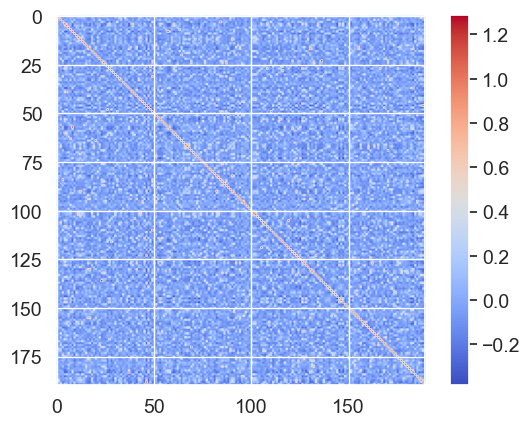

In [13]:
plt.imshow(A)
plt.colorbar()
plt.show()

## K-NN for selecting edges

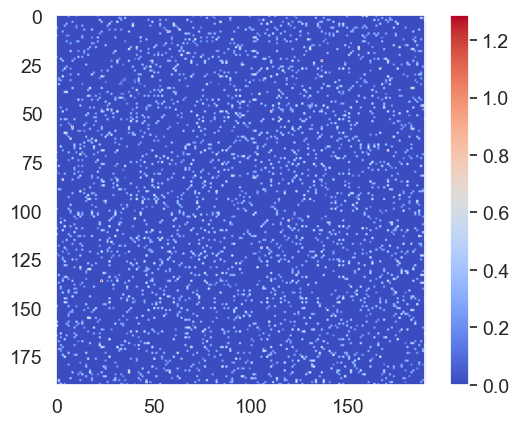

In [14]:
plt.imshow(np.array(compute_KNN_graph(A, 15)))
plt.colorbar()
plt.grid(False)
plt.show()

## Creating the graphs

In [15]:
train_data, val_data = create_graph(X_train, X_test, y_train, y_test, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

In [16]:
print(train_data[-1])

Data(x=[190, 190], edge_index=[2, 2224], edge_attr=[2224, 1], y=1)


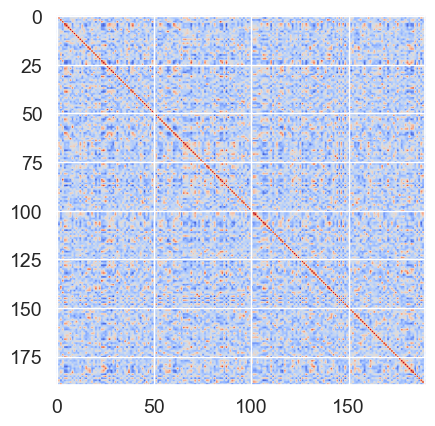

In [17]:
plt.imshow(train_data[-1].x)

In [18]:
train_loader, val_loader = create_batch(train_data, val_data, batch_size=32)

#TRAIN_loader, TEST_loader = create_batch(train_data, TEST_data, batch_size=20)

In [19]:
print('Validation balance \n 0 = {:.2f}% \n'.format(y_test.value_counts()[0]/len(y_test)), '1 = {:.2f}%'.format(y_test.value_counts()[1]/len(y_test)))
print('----------------------')
#print('TEST balance \n 0 = {:.2f}% \n'.format(y_TEST.value_counts()[0]/len(y_TEST)), '1 = {:.2f}%'.format(y_TEST.value_counts()[1]/len(y_TEST)))

Validation balance 
 0 = 0.28% 
 1 = 0.72%
----------------------


In [20]:
import torch
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.3):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(64,32)
        
        #self.gat1 = GATv2Conv(int(num_features), 8, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(148*4, 112, heads=1)
        #self.gat3 = GATv2Conv(128*2, 148, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 128, K=k_order)
        self.conv2 = ChebConv(128, 64, K=k_order)
        #self.conv3 = ChebConv(72, 36, K=k_order)

        self.lin1 = torch.nn.Linear(64, 2)
        #self.lin2 = torch.nn.Linear(4, int(num_classes))
        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


        self.bn1 = torch.nn.BatchNorm1d(148)
        self.bn2 = torch.nn.BatchNorm1d(72)
        self.bn3 = torch.nn.BatchNorm1d(36)
        
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = func.relu(self.conv1(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr) #func.elu(self.gat1(x=x, edge_index = edge_index, edge_attr=edge_attr))
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = func.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat2(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn2(x)
        #x = func.relu(self.conv3(x, edge_index,edge_attr))  #, edge_attr, batch))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn3(x)
            
        #x = func.elu(self.gat3(x, edge_index))
        #x = func.dropout(x, p=self.p, training=self.training)
        
        x = self.pool(x, batch)
        #x = func.log_softmax(x, dim=1)
        x = self.lin1(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = self.lin2(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #print(x.shape)
        return x

In [21]:
def init_weights(m):
    if isinstance(m, GATv2Conv):
        m.reset_parameters()
        if m.bias is not None: 
            nn.init.zeros_(m.bias)
    if isinstance(m, nn.Linear):
        m.reset_parameters()
        #nn.init.normal_(m.weight, mean=0.0, std=np.sqrt(1 / m.in_features))
        if m.bias is not None: 
            nn.init.zeros_(m.bias)


In [22]:
import torch
import torch.nn as nn

# Define the cosine proximity loss function
class CosineProximityLoss(nn.Module):
    def __init__(self):
        super(CosineProximityLoss, self).__init__()
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
    
    def forward(self, y_true, y_pred):
        # y_true and y_pred are tensors of shape (batch_size, num_classes)
        # The loss is the negative of the cosine similarity
        loss = - self.cosine_similarity(y_true, y_pred)
        return loss.mean()
    
#loss = CosineProximityLoss()
#loss = loss(func.softmax(output).max(dim=1).values.reshape(len(y.y),1), y.y.float().reshape(len(y.y),1))
    

# Testing in one fold

In [23]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 1e-4
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    # fpr, tpr, _ = roc_curve(y_true, y_pred)
    # roc_auc = auc(fpr, tpr)
    
    return epoch_acc, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    l1_weight = 1e-4
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
        
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 1e-4
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_rec = tp / (tp + fn)
    epoch_prec = tp / (tp + fp)
    epoch_f1 = 2*(epoch_rec*epoch_prec)/(epoch_rec + epoch_prec)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return epoch_rec, epoch_prec, epoch_acc, loss_all / len(val_data), roc_auc,epoch_f1


In [24]:
metrics = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)

for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
   
model.apply(init_weights)

min_v_loss = np.inf  

NUM_EPOCHS = 150

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1 = GCN_test(val_loader)
    TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['acc_test'].append(test_acc)
    metrics['acc_train'].append(TRAIN_acc)
    
    print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
    print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/150]: 100%|█████████████████| 47/47 [00:06<00:00,  7.00it/s, loss=1.37]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7206896551724138 , Val Loss 1.288966244253619
Train Accuracy 0.6552878179384204 , Train Loss 1.2966818953134926


Epoch [2/150]: 100%|█████████████████| 47/47 [00:06<00:00,  7.13it/s, loss=1.24]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7241379310344828 , Val Loss 1.1770399286829192
Train Accuracy 0.643908969210174 , Train Loss 1.1898131635453966


Epoch [3/150]: 100%|█████████████████| 47/47 [00:08<00:00,  5.31it/s, loss=1.14]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7241379310344828 , Val Loss 1.0694153874084866
Train Accuracy 0.643908969210174 , Train Loss 1.0865606340059795


Epoch [4/150]: 100%|█████████████████| 47/47 [00:06<00:00,  6.96it/s, loss=1.05]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7241379310344828 , Val Loss 0.988548147472842
Train Accuracy 0.643908969210174 , Train Loss 1.0041557684480904


Epoch [5/150]: 100%|████████████████| 47/47 [00:06<00:00,  7.14it/s, loss=0.976]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7241379310344828 , Val Loss 0.9212725160450771
Train Accuracy 0.6465863453815262 , Train Loss 0.9357659398631718


Epoch [6/150]: 100%|████████████████| 47/47 [00:08<00:00,  5.78it/s, loss=0.918]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7241379310344828 , Val Loss 0.8712860869950262
Train Accuracy 0.6532797858099063 , Train Loss 0.8828272849840013


Epoch [7/150]: 100%|████████████████| 47/47 [00:11<00:00,  3.95it/s, loss=0.869]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7275862068965517 , Val Loss 0.8172870670926982
Train Accuracy 0.6539491298527443 , Train Loss 0.8318292275968805


Epoch [8/150]: 100%|████████████████| 47/47 [00:10<00:00,  4.48it/s, loss=0.832]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7275862068965517 , Val Loss 0.7792059219089048
Train Accuracy 0.6693440428380187 , Train Loss 0.7885476479249467


Epoch [9/150]: 100%|████████████████| 47/47 [00:06<00:00,  6.94it/s, loss=0.798]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7275862068965517 , Val Loss 0.7303460391431019
Train Accuracy 0.6633199464524766 , Train Loss 0.75471910128153


Epoch [10/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.70it/s, loss=0.772]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7413793103448276 , Val Loss 0.7020395212132355
Train Accuracy 0.6840696117804551 , Train Loss 0.7159259044820844


Epoch [11/150]: 100%|███████████████| 47/47 [00:09<00:00,  5.15it/s, loss=0.738]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7413793103448276 , Val Loss 0.6772985889993864
Train Accuracy 0.6880856760374833 , Train Loss 0.6928577082383744


Epoch [12/150]: 100%|███████████████| 47/47 [00:09<00:00,  5.16it/s, loss=0.707]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7448275862068966 , Val Loss 0.6548677937223993
Train Accuracy 0.6934404283801874 , Train Loss 0.6773055001115863


Epoch [13/150]: 100%|███████████████| 47/47 [00:08<00:00,  5.26it/s, loss=0.676]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7758620689655172 , Val Loss 0.6338723930819281
Train Accuracy 0.7115127175368139 , Train Loss 0.6584680999418498


Epoch [14/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.37it/s, loss=0.642]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7793103448275862 , Val Loss 0.6137044678474295
Train Accuracy 0.7269076305220884 , Train Loss 0.6431015918213361


Epoch [15/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.67it/s, loss=0.605]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.7965517241379311 , Val Loss 0.5830219876663438
Train Accuracy 0.7663989290495314 , Train Loss 0.604363157008706


Epoch [16/150]: 100%|███████████████| 47/47 [00:09<00:00,  4.85it/s, loss=0.562]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.8275862068965517 , Val Loss 0.548984935828324
Train Accuracy 0.8012048192771084 , Train Loss 0.5612509320059933


Epoch [17/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.45it/s, loss=0.518]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.8448275862068966 , Val Loss 0.5195474515187329
Train Accuracy 0.8199464524765729 , Train Loss 0.5303342153868044


Epoch [18/150]: 100%|███████████████| 47/47 [00:09<00:00,  5.04it/s, loss=0.478]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.8620689655172413 , Val Loss 0.4920481192140744
Train Accuracy 0.8413654618473896 , Train Loss 0.5071328292130786


Epoch [19/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.12it/s, loss=0.443]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.8724137931034482 , Val Loss 0.47042123110129913
Train Accuracy 0.8534136546184738 , Train Loss 0.48821630236135427


Epoch [20/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.64it/s, loss=0.406]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.8896551724137931 , Val Loss 0.44664330261534657
Train Accuracy 0.8748326639892905 , Train Loss 0.45635037265787803


Epoch [21/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.25it/s, loss=0.377]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.896551724137931 , Val Loss 0.42436858908883457
Train Accuracy 0.8888888888888888 , Train Loss 0.42320517874466207


Epoch [22/150]: 100%|███████████████| 47/47 [00:07<00:00,  6.19it/s, loss=0.347]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.9137931034482759 , Val Loss 0.4116785562757788
Train Accuracy 0.8975903614457831 , Train Loss 0.40510158324576767


Epoch [23/150]: 100%|███████████████| 47/47 [00:08<00:00,  5.24it/s, loss=0.324]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.9137931034482759 , Val Loss 0.40151055311334544
Train Accuracy 0.8962516733601071 , Train Loss 0.40201691720619737


Epoch [24/150]: 100%|███████████████| 47/47 [00:10<00:00,  4.68it/s, loss=0.299]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.9137931034482759 , Val Loss 0.38559788958779695
Train Accuracy 0.9176706827309237 , Train Loss 0.35802520568192087


Epoch [25/150]: 100%|███████████████| 47/47 [00:06<00:00,  6.94it/s, loss=0.278]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.9137931034482759 , Val Loss 0.3872714257959662
Train Accuracy 0.9310575635876841 , Train Loss 0.32522159290202013


Epoch [26/150]: 100%|███████████████| 47/47 [00:06<00:00,  7.27it/s, loss=0.264]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.903448275862069 , Val Loss 0.3970327277121873
Train Accuracy 0.927710843373494 , Train Loss 0.3358182648578322


Epoch [27/150]:  94%|██████████████ | 44/47 [00:06<00:00,  6.51it/s, loss=0.242]


KeyboardInterrupt: 


### Debug

In [25]:
model.eval()

GCN(
  (conv1): ChebConv(190, 128, K=3, normalization=sym)
  (conv2): ChebConv(128, 64, K=3, normalization=sym)
  (lin1): Linear(in_features=64, out_features=2, bias=True)
  (bn1): BatchNorm1d(148, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
y_pred = []
for y_i in TEST_loader:
    #print(model(y).detach().numpy()[0][0])
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(np.array(func.softmax(model(y_i), dim=1).detach().max(dim=1)[1]))
    
print('TEST accuracy', accuracy_score(y_TEST.values.reshape(-1,1), y_pred))


NameError: name 'TEST_loader' is not defined

In [27]:
y_pred = []
for y_i in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y_i), dim=1).detach().numpy())#.max(dim=1)[1])

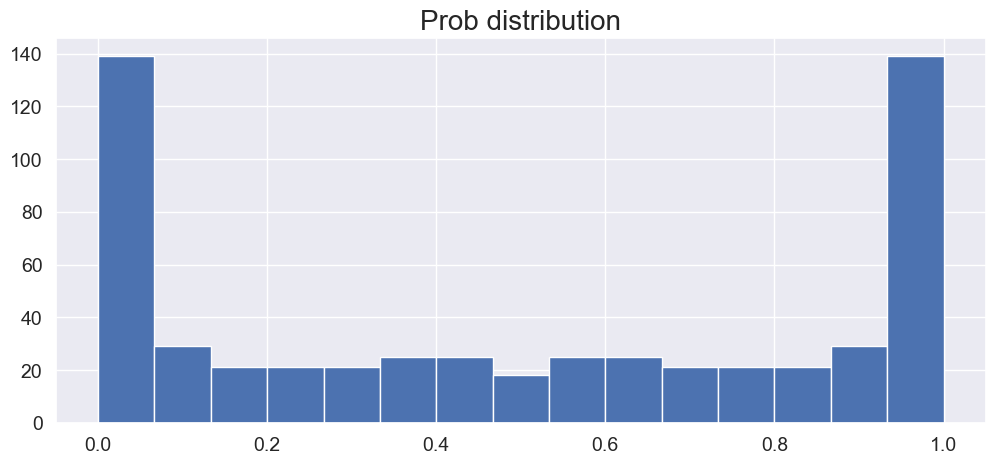

In [28]:
plt.figure(figsize=(12,5))
plt.hist(np.array(y_pred).reshape(len(y_pred)*2), bins=15)
plt.title("Prob distribution")
plt.show()

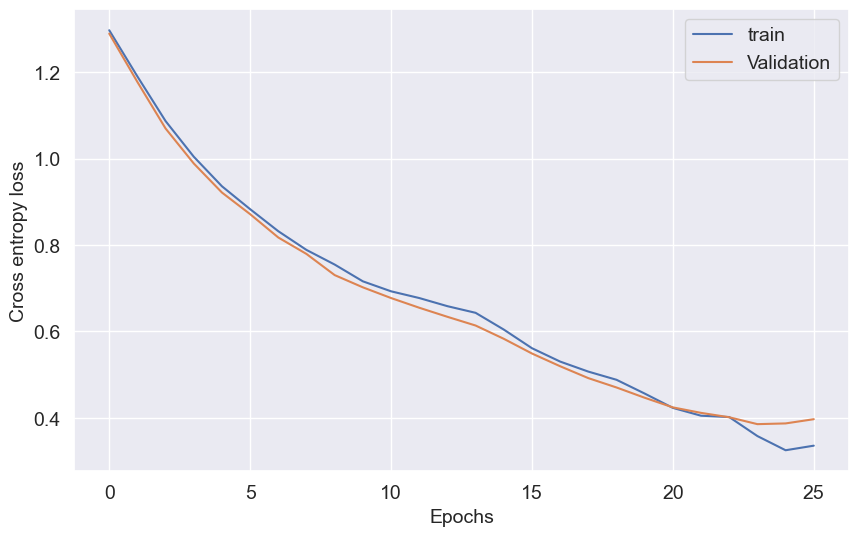

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
#plt.xlim(0,100)
plt.show()

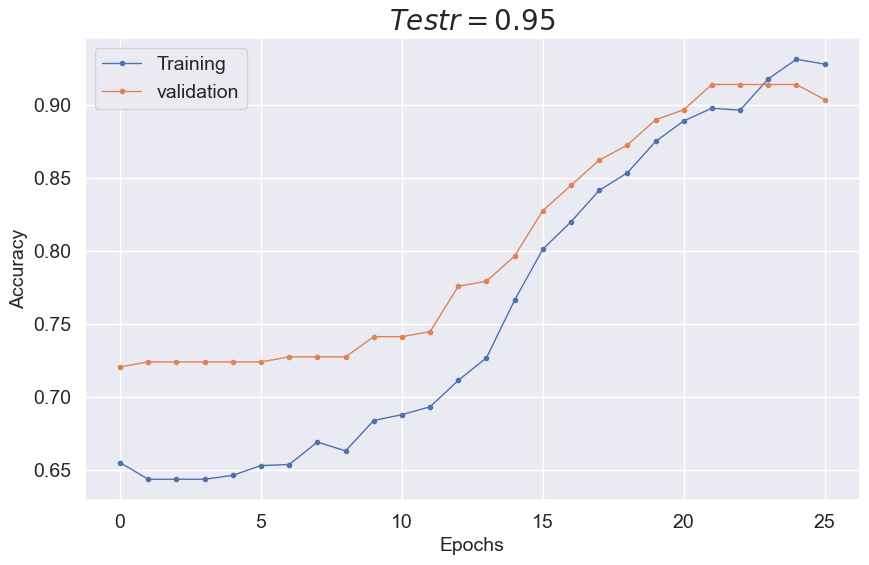

In [30]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['acc_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['acc_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['acc_test'])), metrics['acc_test'])[0][1]))
ax.legend()
plt.show()

## Kfold Cross validation

In [ ]:
inputs = X
targets = y

eval_scores = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

scores = np.zeros((6,10))
# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):
    
    # creating the graphs
    train_data, val_data = create_graph(X.iloc[train], X.iloc[test],
                                         y.iloc[train], y.iloc[test])
    
    # creating the batchs inside the torch DataLoader
    train_loader, val_loader = create_batch(train_data, val_data, batch_size=2)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    
    # Train the NN Archithecture
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,18], gamma=0.1, verbose=True)

    
    model.apply(init_weights)

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    min_v_loss = np.inf  

    NUM_EPOCHS = 9
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_acc, train_loss = GCN_train(train_loader,loop)
        test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1  = GCN_test(val_loader)
    

        eval_scores['loss_train'].append(train_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['acc_test'].append(test_acc)
        eval_scores['acc_train'].append(train_acc)

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_rec
    scores[2][fold_no - 1] = test_prec
    scores[3][fold_no - 1] = test_loss
    scores[4][fold_no - 1] = roc_auc
    scores[5][fold_no - 1] = test_f1

    print(f'Score for fold {fold_no}: loss of {test_loss}; acc of {test_acc}%; AUC of {roc_auc}%')

    # Increase fold number
    fold_no = fold_no + 1

In [ ]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Recall in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Precision in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))
print('Average AUC in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))
print('Average F1 in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['acc_train'])
plt.plot(eval_scores['acc_test'])

In [ ]:
pd.DataFrame(scores.T, columns=['test_acc', 'test_rec_macro',
                                'test_prec_macro', 'test_loss',
                                'test_f1', 'test_roc_auc']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GAT.csv')